![logo](office_logo.png)

##### import libraries

In [11]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(color_codes=True)

#resampling
from io import StringIO
from sklearn.feature_selection import chi2

#bag of words model
from sklearn.feature_extraction.text import CountVectorizer

#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#cross-validation
from sklearn.model_selection import cross_val_score

#classification 
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

#classifier evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

# (3) Machine Learning & Classification

In [12]:
#import cleaned2.csv file
cleaned2_df = pd.read_csv("cleaned2_script_data.csv", index_col=0)

print(cleaned2_df.shape)

(54226, 6)


In [13]:
#import corpus_data.csv file
corpus_df = pd.read_csv("corpus_script_data.csv", index_col=0)

print(corpus_df.shape)
corpus_df.head()

(54226, 1)


,line_text
0,right jim quarterly look good thing library
1,oh told close
2,come master guidance saying grasshopper
3,actually called yeah
4,right well let show done


In [14]:
#append corpus review to cleaned2_df
cleaned2_df['line_corpus'] = corpus_df['line_text']
cleaned2_df.head(1)

,season,episode,scene,line_text,speaker,deleted,line_corpus
0,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False,right jim quarterly look good thing library


In [15]:
#locate NaN
is_NaN = cleaned2_df.isna()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = cleaned2_df[row_has_NaN]

#remove NaN
cleaned2_df = cleaned2_df.dropna()
print(cleaned2_df.isna().sum())
print(cleaned2_df.shape)

season         0
episode        0
scene          0
line_text      0
speaker        0
deleted        0
line_corpus    0
dtype: int64
(52133, 7)


In [16]:
#choose Michael and Dwight

options = ['Michael',
           'Dwight']
  
# selecting rows based on condition 
cleaned3_df = cleaned2_df[cleaned2_df['speaker'].isin(options)] 
cleaned3_df.shape

(19003, 7)

#### First, remove missing values in "line_corpus" column, and add a column representing the speaker as an integer since categorical variables are better represented by integers.

In [18]:
col = ['speaker', 'line_corpus']
cleaned3_df = cleaned3_df[col]
cleaned3_df = cleaned3_df[pd.notnull(cleaned3_df['line_corpus'])]
cleaned3_df.columns = ['speaker', 'line_corpus']
cleaned3_df['speaker_id'] = cleaned3_df['speaker'].factorize()[0]
speaker_id_df = cleaned3_df[['speaker', 'speaker_id']].drop_duplicates().sort_values('speaker_id')

#add dictionaries for future use
speaker_to_id = dict(speaker_id_df.values)
id_to_category = dict(speaker_id_df[['speaker_id', 'speaker']].values)

cleaned3_df = cleaned3_df.reset_index()
del cleaned3_df['index']
print(cleaned3_df.shape)
cleaned3_df.head()


(19003, 3)


,speaker,line_corpus,speaker_id
0,Michael,right jim quarterly look good thing library,0
1,Michael,come master guidance saying grasshopper,0
2,Michael,right well let show done,0
3,Michael,phone yes like speak office manager please yes...,0
4,Michael,uh dunder mifflin year last four regional mana...,0


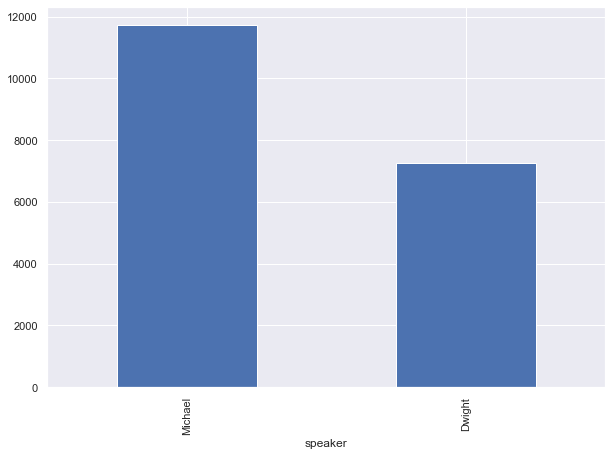

In [19]:
#plot speaker counts
fig = plt.figure(figsize=(10,7))
cleaned3_df.groupby('speaker').line_corpus.count().sort_values(ascending=False).plot.bar(ylim=0)
plt.show()

The classifiers and learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. Therefore, during the preprocessing step, the texts are converted to a more manageable representation.

- sublinear_df is set to True to use a logarithmic form for frequency.
- min_df is the minimum numbers of documents a word must be present in to be kept.
- norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
- ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.

In [20]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(cleaned3_df.line_corpus).toarray()
labels = cleaned3_df.speaker_id
features.shape

(19003, 3939)

Now, each line in the line_corpus is represented by features, representing the tf-idf score for different unigrams and bigrams.
We can use sklearn.feature_selection.chi2 to find the lines that are the most correlated with each of the speaker:

In [21]:
N = 2
for speaker, speaker_id in sorted(speaker_to_id.items()):
  features_chi2 = chi2(features, labels == speaker_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(speaker))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Dwight':
  . Most correlated unigrams:
. schrute
. michael
  . Most correlated bigrams:
. michael scott
. dwight schrute
# 'Michael':
  . Most correlated unigrams:
. schrute
. michael
  . Most correlated bigrams:
. michael scott
. dwight schrute


### Resampling

In [22]:
cleaned3_df.head(1)

,speaker,line_corpus,speaker_id
0,Michael,right jim quarterly look good thing library,0


In [23]:
msk = np.random.rand(len(cleaned3_df)) < 0.75

train_df = cleaned3_df[msk]
test_df = cleaned3_df[~msk]

In [24]:
print(len(test_df))
print(len(train_df))

4741
14262


In [25]:
#split test into X_test and y_test for later
y_test = test_df['speaker_id']
X_test = test_df.drop('speaker_id',axis=1)
print(train_df['speaker_id'].value_counts())

0    8766
1    5496
Name: speaker_id, dtype: int64


In [26]:
#class count
count_class_0, count_class_1 = train_df.speaker_id.value_counts()

#divide by class
df_class_0 = train_df[train_df['speaker_id'] == 0]
df_class_1 = train_df[train_df['speaker_id'] == 1]

##### Random Over-Sampling

Random over-sampling:
1    8766
0    8766
Name: speaker_id, dtype: int64


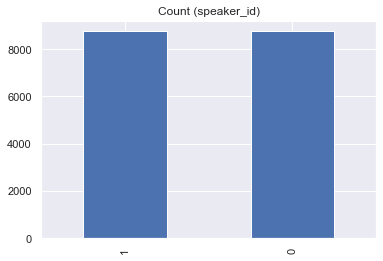

In [27]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_1_over, df_class_0], axis=0)

print('Random over-sampling:')
print(df_test_over.speaker_id.value_counts())

df_test_over.speaker_id.value_counts().plot(kind='bar', title='Count (speaker_id)')

##### Random Under-Sampling

Random under-sampling:
1    5496
0    5496
Name: speaker_id, dtype: int64


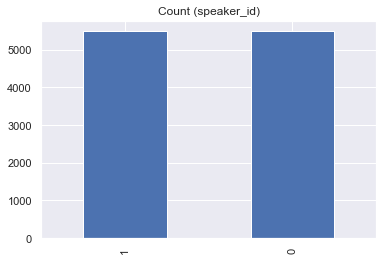

In [28]:
df_class_0_under = df_class_0.sample(count_class_1, replace=True)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.speaker_id.value_counts())

df_test_under.speaker_id.value_counts().plot(kind='bar', title='Count (speaker_id)')

### Classification Algorithms with Oversampled Data

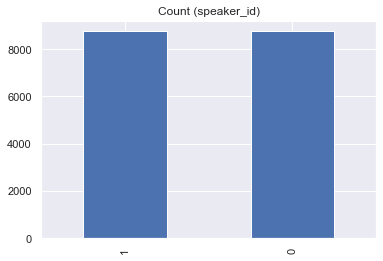

In [29]:
df2_test_over = pd.DataFrame(df_test_over)
df2_test_over.speaker_id.value_counts().plot(kind='bar', title='Count (speaker_id)');

In [30]:
#split into X_train and y_train
X_over_train = df2_test_over.drop('speaker_id',axis=1)
y_over_train = df2_test_over['speaker_id']

In [31]:
#use all n-grams(2) from train set in bag of words model
cv = CountVectorizer(ngram_range = (2, 2)) 
X_vec_train = cv.fit_transform(X_over_train['line_corpus'])
X_vec_train.shape

(17532, 61614)

In [32]:
#apply TDIDF on train set
tfidf_transformer = TfidfTransformer()
train_over_tfidf = tfidf_transformer.fit_transform(X_vec_train)
train_over_tfidf.shape

(17532, 61614)

In [33]:
#use all n-grams(2) from test set in bag of words model
X_vec_test = cv.transform(X_test['line_corpus'])
X_vec_test.shape

(4741, 61614)

In [34]:
#apply TDIDF on test set
test_over_tfidf = tfidf_transformer.transform(X_vec_test)
test_over_tfidf.shape

(4741, 61614)

##### Naive Bayes

In [35]:
##fitting Naive Bayes to the training set
nb_classifier = MultinomialNB()
nb_classifier = nb_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = nb_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[2498  471]
 [1293  479]]


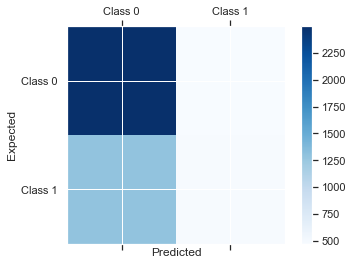

In [36]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [37]:
accText = 'Naive Bayes, Oversampling'

In [38]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions, average='weighted')).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions, average='weighted')).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions, average='weighted')).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

  Accuracy: 62.79%
 Precision: 60.11%
    Recall: 62.79%
  F1 score: 59.44%


In [39]:
acc = pd.read_csv("office_accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.to_csv("office_accuracies.csv")

##### K-Nearest Neighbours

In [40]:
#find optimal K-number with cross-validation

#creating odd list of K for KNN
neighbors = list(range(1, 15, 2))

#empty list that will hold cv scores
cv_scores = []

#perform 10-fold cross validation
for k in neighbors:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, train_over_tfidf, y_over_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbours is 5


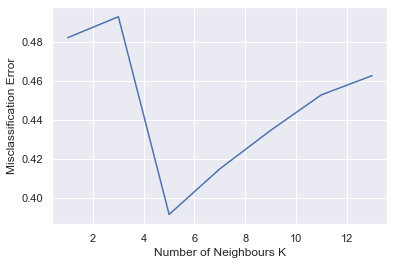

In [41]:
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbours is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbours K")
plt.ylabel("Misclassification Error")
plt.show()

In [42]:
#fitting KNN to the training set
knn_classifier = KNeighborsClassifier(n_neighbors = 5, weights = 'distance', metric = 'cosine')
knn_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = knn_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[2426  543]
 [1347  425]]


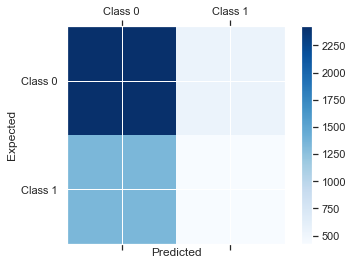

In [43]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [44]:
accText = 'KNN, Oversampling'

In [45]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions, average='weighted')).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions, average='weighted')).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions, average='weighted')).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

  Accuracy: 60.13%
 Precision: 56.68%
    Recall: 60.13%
  F1 score: 56.66%


In [46]:
acc = pd.read_csv("office_accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.to_csv("office_accuracies.csv")

##### Support Vector Model

In [47]:
#fitting SVM to the training set
svm_classifier = SGDClassifier(loss='perceptron', penalty='l2')
svm_classifier.fit(train_over_tfidf, y_over_train)

#predicting the test set results
predictions = svm_classifier.predict(test_over_tfidf)

Confusion matrix:
 [[2572  397]
 [1376  396]]


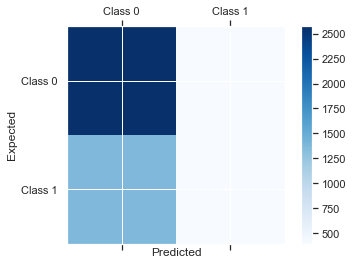

In [48]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [49]:
accText = 'SVM, Oversampling'

In [50]:
#calculate accuracy/precision/recall/f1

# accuracy: (tp + tn) / (p + n)
accuracy = (accuracy_score(y_test, predictions)).astype('float64')
print('{:>10}: {:0.2%}'.format('Accuracy',accuracy))
# precision tp / (tp + fp)
precision = (precision_score(y_test, predictions, average='weighted')).astype('float64')
print('{:>10}: {:0.2%}'.format('Precision',precision))
# recall: tp / (tp + fn)
recall = (recall_score(y_test, predictions, average='weighted')).astype('float64')
print('{:>10}: {:0.2%}'.format('Recall',recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = (f1_score(y_test, predictions, average='weighted')).astype('float64')
print('{:>10}: {:0.2%}'.format('F1 score',f1))

  Accuracy: 62.60%
 Precision: 59.46%
    Recall: 62.60%
  F1 score: 58.11%


In [51]:
acc = pd.read_csv("office_accuracies.csv", index_col=0)
acc.at[accText, 'Accuracy'] = (accuracy)
acc.at[accText, 'Precision'] = (precision)
acc.at[accText, 'Recall'] = (recall)
acc.at[accText, 'F1'] = (f1)
acc.to_csv("office_accuracies.csv")

##### Towards Data Science Method

In [52]:
#split train.test set
X_train, X_test, y_train, y_test = train_test_split(cleaned3_df['line_corpus'], cleaned3_df['speaker'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#define classifier
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [53]:
print(clf.predict(count_vect.transform(["I am the new assistant."])))

['Dwight']


In [54]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=1)

plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [19003, 2]

In [55]:
cv_df.groupby('model_name').accuracy.mean()

KeyError: 'model_name'

In [56]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, cleaned3_df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=speaker_id_df.speaker.values, yticklabels=speaker_id_df.speaker.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [19003, 2, 19003]